<a href="https://colab.research.google.com/github/ferit-qc/lab4/blob/main/lab4_grovers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab4. - Implementation of Grover's Search Algorithm and Walk Algorithms

## Useful learning resources and links:
* [Quantum computing documentation](https://docs.quantum.ibm.com/)
* [Qiskit documentation](https://www.ibm.com/quantum/qiskit)
* [IBM Quantum Composer](https://quantum.ibm.com/composer)


Lets first install everything we need for this excersise:

In [6]:
!apt-get install python3.11-venv
!python3.11 -m venv qiskit_env
!source qiskit_env/bin/activate
!pip install qiskit==0.44.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.11-venv is already the newest version (3.11.12-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Using cached qiskit-0.44.2-py3-none-any.whl.metadata (8.2 kB)
  Using cached qiskit_terra-0.25.2.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.0 kB)
  Using cached symengine-0.9.2-cp311-cp311-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (1.1 kB)
Using cached qiskit-0.44.2-py3-none-any.whl (8.2 kB)
Using cached qiskit_terra-0.25.2.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.2 MB)
Using cached symengine-0.9.2-cp311-cp311-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.6 MB)
  Attempting uninstall: symengine
    Found existing installation: symengine 0.13.0
    Uninstalling symengine-0.13.0:
      Successfully uninstalled symengine-0.13.0
  Attempting uninstall: qiskit-terra
    Found existing installation: 

In [7]:
!pip install qiskit qiskit-ibm-runtime

  Using cached qiskit-2.0.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
INFO: pip is looking at multiple versions of qiskit to determine which version is compatible with other requirements. This could take a while.
  Using cached qiskit-1.4.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached qiskit-1.4.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached qiskit_ibm_runtime-0.38.0-py3-none-any.whl.metadata (21 kB)
INFO: pip is still looking at multiple versions of qiskit to determine which version is compatible with other requirements. This could take a while.
  Using cached qiskit-1.4.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run,

In [8]:
!pip install qiskit qiskit-aer

In [9]:
!pip install matplotlib

In [10]:
!pip install pylatexenc

In [11]:
from qiskit import *   # Imports core Qiskit classes (QuantumCircuit, transpile, etc.)
from qiskit_aer.aerprovider import AerSimulator # Provides access to the local quantum circuit simulator
from qiskit.visualization import plot_histogram # Enables visualization of measurement results
import matplotlib.pyplot as plt # Standard Python plotting library
from IPython.display import display # Allows rich display of plots in Jupyter notebooks
from IPython.display import Image
from IPython.core.display import HTML
import math
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
import numpy as np

## 1. Introduction <a id='introduction'></a>

You have likely heard that one of the many advantages a quantum computer has over a classical computer is its superior speed searching databases. Grover's algorithm demonstrates this capability. This algorithm can speed up an unstructured search problem quadratically, but its uses extend beyond that; it can serve as a general trick or subroutine to obtain quadratic run time improvements for a variety of other algorithms. This is called the amplitude amplification trick.    


Suppose you are given a large list of $N$ items. Among these items there is one item with a unique property that we wish to locate; we will call this one the winner $w$. Think of each item in the list as a box of a particular color. Say all items in the list are gray except the winner $w$, which is purple.


![screenshot_1743358170516.png](<https://media-hosting.imagekit.io/5db6f7848a3b4ab6/screenshot_1743358170516.png?Expires=1837966170&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=s-zGFi8x2agZWrvbewcled2heEN9WPGCNKirvIt8JpJ9CL1Ksu6LJOkHhcLdvWHsm2kZj2-89HLO6xDVkpnBl3ahgFk3Enicp9j7vBGZSg51EtOCafiEM6ltwPy5~3HuRW8WVzyw4faC2XgopToBq-IgxOsq~uPMHjxPj3pjOYyJfx7ZsDFwbR9suG-ntj3Q9FvREreBSXGIuSBlZc7aK661A958dNyWQkxbU567F5e85YcAKkkbiKmLiYYILdTGbbtN2oYVLhrZrGUxJLLqEanW~tR9VnbdcVS24PNPbfchHns~4kfs7AmWAVaD3vZ0lF1fNMJ8lo9IcXlXmbM~Jg__>)

To find the purple box -- the *marked item* -- using classical computation, one would have to check on average $N/2$ of these boxes, and in the worst case, all $N$ of them. On a quantum computer, however, we can find the marked item in roughly $\sqrt{N}$ steps with Grover's amplitude amplification trick. A quadratic speedup is indeed a substantial time-saver for finding marked items in long lists. Additionally, the algorithm does not use the list's internal structure, which makes it *generic;* this is why it immediately provides a quadratic quantum speed-up for many classical problems.


### 1.1 Algorithm Overview


Grover's algorithm consists of three main algorithms steps: state preparation, the oracle, and the diffusion operator. The state preparation is where we create the search space, which is all possible cases the answer could take. In the list example we mentioned above, the search space would be all the items of that list.    
The oracle is what marks the correct answer, or answers we are looking for, and the diffusion operator magnifies these answers so they can stand out and be measured at the end of the algorithm.

![screenshot_1743358193016.png](<https://media-hosting.imagekit.io/fcc7df39b31c4409/screenshot_1743358193016.png?Expires=1837966193&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=Ru7vcfn83~cdTgTgGHQFW6n3TBdv86PIvHKoJ3RpuuG3ZJ3ptuSHB-j40zyZ4qbu6WfYMnd88s~NoXRf0DuOeq6KH5WFe7P59oZiF7OC178yaTSIA99gTRZUcRl9mhSKNoy5dnIOCFsef83UuWtkJe1TkSH84BPAaJ1rvmAiWqfOXYCE~lA258zkyFWQtWAtc-LoYfOVzQYazudygUfiv-~oqLJ1BPpU9WmzcPra0uedogRoTA1BJr8Lh6BjJO1ffM-DbV21sCMjgCuUAOR9fpNFnT~3J7DFZz43Sv4b1CFshAm2EX7bxJojCZ8PyXWZeORub1TeZd72z962YRk3zQ__>)   


So how does the algorithm work? Before looking at the list of items, we have no idea where the marked item is. Therefore, any guess of its location is as good as any other, which can be expressed in terms of a
uniform superposition: $|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0}^{N -1} | x
\rangle.$

If at this point we were to measure in the standard basis $ \{ | x \rangle \} $, this superposition would collapse, according to the fifth quantum law, to any one of the basis states with the same probability of $\frac{1}{N} = \frac{1}{2^n}$. Our chances of guessing the right value $w$ is therefore $1$ in $2^n$, as could be expected. Hence, on average we would need to try about $N/2 = 2^{n-1}$ times to guess the correct item.

Enter the procedure called amplitude amplification, which is how a quantum computer significantly enhances this probability. This procedure stretches out (amplifies) the amplitude of the marked item, which shrinks the other items' amplitude, so that measuring the final state will return the right item with near-certainty.

This algorithm has a nice geometrical interpretation in terms of two reflections, which generate a rotation in a two-dimensional plane. The only two special states we need to consider are the winner $| w \rangle$ and the uniform superposition $| s \rangle$. These two vectors span a two-dimensional plane in the vector space $\cssId{vspace}{\mathbb{C}^N}$. They are not quite perpendicular because $| w \rangle$ occurs in the superposition with amplitude $N^{-1/2}$ as well.
We can, however, introduce an additional state $|s'\rangle$ that is in the span of these two vectors, which is perpendicular to $| w \rangle$ and is obtained from $|s \rangle$ by removing $| w \rangle$ and
rescaling.

**Step 1**: The amplitude amplification procedure starts out in the uniform superposition $| s \rangle$, which is easily constructed from $| s \rangle = H^{\otimes n} | 0 \rangle^n$ or using another symmetric entangled states.

![screenshot_1743358252873.png](<https://media-hosting.imagekit.io/ca5fd105a8394453/screenshot_1743358252873.png?Expires=1837966253&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=cROI~qoXkWxKfi8WDvsnpDshJe5OvnFbACsrA-a5OLliIvGqROAXa9vsxehPlghhvv7KDnKqcFGtopuNRJYGhumCLNmMwcVuT6wNdBoMfqMuRgcXj-S3iA4htbkGV5CeU~DhvjHjfBsHVRJntf6Tva5kdn6wPXHuZVrU3KKjbZcXzP3z3Q3nl8p-1YMD~zuJvdYNeFnpskDTfZw1kl4cHm0UtZyTHyHDpl0kYX6GfhIuUeHTArEEo3-cpdcLhDh2rfcWfd133r10ejo4RlvlgbFNFkw4TKLSJo9mxrG8Ea51bxy-rt2Go0gv-Z8YJE74butCoFhNFQpxmxnlFVpyLw__>)

The left graphic corresponds to the two-dimensional plane spanned by perpendicular vectors $|w\rangle$ and $|s'\rangle$ which allows to express the initial state as $|s\rangle = \sin \theta | w \rangle + \cos \theta | s' \rangle,$ where $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$. The right graphic is a bar graph of the amplitudes of the state $| s \rangle$.

**Step 2**: We apply the oracle reflection $U_f$ to the state $|s\rangle$.

![screenshot_1743358273837.png](<https://media-hosting.imagekit.io/c3ef6edf47b14f64/screenshot_1743358273837.png?Expires=1837966274&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=hZuJtOk~U7YgEYlKv57w-LIDyZoCU5EJX4KRnf0PO31Lv21qcyHkRakWYpuk4jGFeZy4QalnKeyi2m6pGLWTxReVzTpPbdk4NqIJfGhaXOIfzQEOg393oWqGSGzveIFRJkVUAGwy4-Wa2EhlnKfEPohwiBqyetIzTjrX9b9IR8EU5lPW14XASgh-0cd5iatf0Sk5CH4j3OOf0afJU4YOSyj1UN3h1b23YASIbCiYdxa6RbHSf2sKARNGPuagTGRrnufqQLrRashNbQuGx7oBXtoMouspf~dwAJbZTWdXEYVnL4cyQuJCmMI7-TPFZNSHYpf8AF0dxOdwxwWzdvu1jA__>)

Geometrically this corresponds to a reflection of the state $|s\rangle$ about $|s'\rangle$. This transformation means that the amplitude in front of the $|w\rangle$ state becomes negative, which in turn means that the average amplitude (indicated by a dashed line) has been lowered.

**Step 3**: We now apply an additional reflection ($U_s$) about the state $|s\rangle$: $U_s = 2|s\rangle\langle s| - \mathbb{1}$. This transformation maps the state to $U_s U_f| s \rangle$ and completes the transformation.

![screenshot_1743358288944.png](<https://media-hosting.imagekit.io/4b469fd7b4cc412c/screenshot_1743358288944.png?Expires=1837966289&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=MedNG4wLUcsclTwDcS3q7aQ7bBoKKuP~K0mmyEirk5opSd7MUxfJ6nLld1JsgSVNJyfbMGh0Zy6jykPsRTCvW1LZCHd0-tGG3yfvrypC7A6VwySsnNqQeMneJXBI5JlN9~jBUFg8gBVb-t69pUDG0eibR0MolTS5t7l8XZU7wC07Sk4YyrUruTHhIoDjbUiYLMKjTg-xoM3n~6qczEV4gLBsQSHWe8HdjUtSJ7x6ayuv5YZF3xHBYBm6bft62pbYjAL9EAqJ4yt4Zuw~l5-fwYtyXfFZI4zePioiQyrCHdAo9O5tORKjiKYVSs5ha-5CNC2gHtgp3e0BIkezLewa7g__>)

Two reflections always correspond to a rotation. The transformation $U_s U_f$ rotates the initial state $|s\rangle$ closer towards the winner $|w\rangle$. The action of the reflection $U_s$ in the amplitude bar diagram can be understood as a reflection about the average amplitude. Since the average amplitude has been lowered by the first reflection, this transformation boosts the negative amplitude of $|w\rangle$ to roughly three times its original value, while it decreases the other amplitudes. We then go to **step 2** to repeat the application. This procedure will be repeated several times to zero in on the winner.

After $t$ steps we will be in the state $|\psi_t\rangle$ where: $| \psi_t \rangle = (U_s U_f)^t  | s \rangle.$

How many times do we need to apply the rotation? It turns out that roughly $\sqrt{N}$ rotations suffice. This becomes clear when looking at the amplitudes of the state $| \psi \rangle$. We can see that the amplitude of $| w \rangle$ grows linearly with the number of applications $\sim t N^{-1/2}$. However, since we are dealing with amplitudes and not probabilities, the vector space's dimension enters as a square root. Therefore it is the amplitude, and not just the probability, that is being amplified in this procedure.

To calculate the number of rotations we need to know the size of the search space and the number of answers we are looking for. The get the optimal number of iterations $t$, we can follow the equation:     

$$
t = \lfloor\frac{\pi}{4}\sqrt{\frac{N}{m}}\rfloor
$$

Where N is the size of the search space and m is the number of answers we want.


![screenshot_1743358309952.png](<https://media-hosting.imagekit.io/c9754693436f44af/screenshot_1743358309952.png?Expires=1837966310&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=iH8bgrlSFXqacr-QNAPhWpzY~PzTsBDsR0~Woi4MkO7Gcr6YQcxSdDm0ohMFlE1pGhmHYlcTDOAF4~TiAigzJubzkgtOSUI3VmEbFfngYJtO~jyUXCqP9c5iELTVXI2eUKZXsRg6PsqnjBnrNI25~2uHLxwA3nhRSS34Fhc-IwkmmyAJuuCdWHTAloSrI~1ZYcP0sxtpEaiGYWJvetU9RlNpRf2vcN45Scu8l1C4HcbTebrAQFcdxeNiJeq~flGoYGLikWJzOr7CvDWV~1mFcetg2N6wxlSIRtBL64luP~QWE-xKpLNjiOlSlPqky1dve~RN0zi-8vw3-58aX~zrIw__>)

&nbsp;

## 1.2 Grover Step by Step <a id='step'></a>

Now that we went through how Grover's algorithm actually work, let's go a little bit in depth about the construction and different cases for each of its components.

##  1.2.1 Preparing the Search Space <a id='state-prep'></a>

The first step of Grover's algorithm is the initial state preparation. As we just mentioned, the search space is all possible values we need to search through to find the answer we want. For the examples in this textbook, our 'database' is comprised of all the possible computational basis states our qubits can be in. For example, if we have 3 qubits, our list is the states $|000\rangle, |001\rangle, \dots |111\rangle$ (i.e the states $|0\rangle \rightarrow |7\rangle$). So, in this case the size of our search space will be $N = 2^{3} = 8$.

In some cases, if we know the range within the search space where the answer is guaranteed to be, we can eliminate the redundant basis out of our search space to speed up the algorithm and decrease the size of the circuit. Generally speaking, we can prepare our state using any symmetric states, such as GHZ-states, W-states, or Dicke-states.

For example, if we are trying to solve a problem with one answer using 4 qubits, and we prepare our state using the Hadamard gate (i.e. forming the Hilbert Space), N will be 16. But, if we know that the answer is within states when only one qubit has the value of 1 at any time, we can then use the W-state instead of the full Hilbert space to prepare our states. Doing that, decreased the size of the search space from 16 to 4 and the number of optimal iterations $t$ from 3 to 1.

## 1.2.2 Creating the Oracle

The second and most important step of Grover’s algorithm is the oracle. Oracles add a negative phase to the solution states so they can standout from the rest and be measured. I.e. for any state $|x\rangle$ in the computational basis:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

This oracle will be a diagonal matrix, where the entry that correspond to the marked item will have a negative phase. For example, if we have three qubits and $\omega = \text{101}$, our oracle will have the matrix:

$$
U_\omega =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\\
\\
\\
\leftarrow \omega = \text{101}\\
\\
\\
\\
\end{aligned}
$$


What makes Grover’s algorithm so powerful is how easy it is to convert a problem to an oracle of this form. There are many computational problems in which it is difficult to _find_ a solution, but relatively easy to _verify_ a solution. For example, we can easily verify a solution to a sudoku by checking all the rules are satisfied. For these problems, we can create a function $f$ that takes a proposed solution $x$, and returns $f(x) = 0$ if $x$ is not a solution ($x \neq \omega$) and $f(x) = 1$ for a valid solution ($x = \omega$). Our oracle can then be described as:

$$
U_\omega|x\rangle = (-1)^{f(x)}|x\rangle
$$

and the oracle's matrix will be a diagonal matrix of the form:

$$
U_\omega =
\begin{bmatrix}
(-1)^{f(0)} &   0         & \cdots &   0         \\
0           & (-1)^{f(1)} & \cdots &   0         \\
\vdots      &   0         & \ddots & \vdots      \\
0           &   0         & \cdots & (-1)^{f(2^n-1)} \\
\end{bmatrix}
$$



<p>
If we have our classical function $f(x)$, we can convert it to a reversible circuit of the form:

![screenshot_1743358561343.png](<https://media-hosting.imagekit.io/41d5bedfbe5a4e74/screenshot_1743358561343.png?Expires=1837966561&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=n7SQOeeR0KU-3FPiV7e36S2B9t2mtdmkcTsm1~X5VXhQ6WZy-5S3CXiv4mNVhNbPEntIcQg3Ujza-FAujwE11iS7RMw09-e04v8jyUm49GMQJiVNlM98EcXC6PAy2mvGAHtZHS9e~4YrIwqg970uZZ3wU7t7IVeTwPyZsMFixQoBZd64r769cy9MypX-VVSTqPuzNesYSOFf6bKBtWBVUpy1G54o9EjCRPkOeNsNDHPEzrZay1aoz-eF7--rnNa1Xcb0SG1z1deIaiQYOIIjtxZqIBGfYK~G5j3Nd8tHw7MvIgxjZbGMfG0RnkrSwawgFHLO2JaysmeHsoJl1v2Kbw__>)

If we initialize the 'output' qubit in the state $|{-}\rangle$, the phase kickback effect turns this into a Grover oracle (similar to the workings of the Deutsch-Jozsa oracle):

![screenshot_1743358600351.png](<https://media-hosting.imagekit.io/4d9e1ae240624cdc/screenshot_1743358600351.png?Expires=1837966600&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=sKzNRolWOlcTJvJB4R45nW~UC~hBjPFw11NMUzN3jfKg7TWZ4kcaJpzMt2lVWE65lca9UGRSOvJf1yMUIxmxPhFms2PKg5GFDwthfPayS7kS9e6UUD2PHZ1r1fYCyyqzZ3s7mfGxCBxjp8C~29xLM~33j2Ywett-dA1mH1B8baN7h-yYwsrIdljF3BrbzXbFm0OnCts0aoXYKNRdtG5KqK~hM5K1SWa4TfQaHk9S6aYWsgcWYYCW-IZTxXkZsH9dLAyraOD~U~os4f8gg1hyAOooE2lSA81otqbgs59pkJuuuSv6a0DX1Ezgjy7k1dnLVBYlZZz4f3fSpVEM-nUiHA__>)

We then ignore the auxiliary ($|{-}\rangle$) qubit.
</p>





##  1.2.3 The Diffusion Operator <a id='diffusion'></a>

Finally, after the oracle has marked the correct answer by making it negative, the last step of Grover's algorithm which is the diffusion operator.

The construction of the diffusion operator depends on what we decide to use to prepare our initial states. Generally, the diffusion operator has the following construction.

![screenshot_1743358636646.png](<https://media-hosting.imagekit.io/6c12f2ebcdc64acd/screenshot_1743358636646.png?Expires=1837966636&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=dNYxy03bflrseYnCN6ayTiG8PcFt~XE19AqZlsfub8JAfWCbBSUvbMH52ymWbuOLyHN4hS4AHCHhc-KADvyaAX9S-XPbjvJucd9Eng1gRnZHi9C7X9gEHCoCuJWNhHsSRciNr4YCjALmBk1og7DVIDqdH364y9v04zPm9tJ0U5snm1nVPn2kSmdSCncNlY-gx5OCKPY3JcqCI~pAddbdBOdwekDBza-WT7KwB7ydNHnyNuNo7Zu9EVRJeM-6wuZxylQfvBuwrVNioUzFeQ6RLzkmXh~tXi2MQ~oFCb-L1oLOgeN44cYBbpBCR7D4PL936h5~Zohb8sj3MCCPmqEgXw__>)

For the next part of this chapter, we will create example oracles where we know $\omega$ beforehand, and not worry ourselves with whether these oracles are useful or not. At the end of the chapter, we will cover a short example where we create an oracle to solve a problem (sudoku) and a famous graph problem, the triangle finding problem.

## 2. Example: 2 Qubits <a id='2qubits'></a>

Let's first have a look at the case of Grover's algorithm for $N=4$ which is realized with 2 qubits. In this particular case, only <b>one rotation</b> is required to rotate the initial state $|s\rangle$ to the winner $|w\rangle$[3]:

1. Following  the above introduction, in the case $N=4$ we have

   $$\theta = \arcsin \frac{1}{2} = \frac{\pi}{6}.$$

2. After $t$ steps, we have

   $$(U_s U_\omega)^t  | s \rangle = \sin \theta_t | \omega \rangle + \cos \theta_t | s' \rangle ,$$
   
   where
   
   $$\theta_t = (2t+1)\theta.$$

3. In order to obtain $| \omega \rangle$ we need $\theta_t = \frac{\pi}{2}$, which with $\theta=\frac{\pi}{6}$ inserted above results to $t=1$. This implies that after $t=1$ rotation the searched element is found.


We will now follow through an example using a specific oracle.

#### Oracle for $\lvert \omega \rangle = \lvert 11 \rangle$
Let's look at the case $\lvert w \rangle = \lvert 11 \rangle$. The oracle $U_\omega$ in this case acts as follows:

$$U_\omega | s \rangle = U_\omega \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right).$$

or:

$$
U_\omega =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1 \\
\end{bmatrix}
$$

which you may recognise as the controlled-Z gate. Thus, for this example, our oracle is simply the controlled-Z gate:

![screenshot_1743358657952.png](<https://media-hosting.imagekit.io/64e5deffbb874d36/screenshot_1743358657952.png?Expires=1837966658&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=qqAYhHDjkmlFJyGSvCzNtL4WwdUqT9Rus0f7PQ7Icu0bYJYdlvCY86YKBBeElzdgDcf9omM0VQuP9vAk6vXWMHF4Zu7A50YurqgUixLM99vyTXcDAEldR2eMAHOKK1ePEf07EUqS3e9-AQBlOVfDfOs-NrZa5hBXLEfRAZQzLVc8vjYlxIXpabamnViCkVhttEQeE7bozKSpr5Rw~4~LcepkSRdt-dBwZXB7ZQFSzZgNaFAvi4gKnlqlMirKGbIzXGEyRWr-S1j7Fz3J0Nn2dSCiudtNAlFKhkSim4pgFPq90g2Grmi-YUqc1qRYMKMCr7EzEjPvUyv6vHnDHIOG2g__>)

#### Reflection $U_s$

In order to complete the circuit we need to implement the additional reflection $U_s = 2|s\rangle\langle s| - \mathbb{1}$. Since this is a reflection about $|s\rangle$, we want to add a negative phase to every state orthogonal to $|s\rangle$.

One way we can do this is to use the operation that transforms the state $|s\rangle \rightarrow |0\rangle$, which we already know is the Hadamard gate applied to each qubit:

$$H^{\otimes n}|s\rangle = |0\rangle$$

Then we apply a circuit that adds a negative phase to the states orthogonal to $|0\rangle$:

$$U_0 \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right)$$

i.e. the signs of each state are flipped except for $\lvert 00 \rangle$. As can easily be verified, one way of implementing $U_0$ is the following circuit:

![screenshot_1743358674658.png](<https://media-hosting.imagekit.io/3f42cd6e20fc44f3/screenshot_1743358674658.png?Expires=1837966674&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=fa20HH8sRGv0w3lxP~1fkZoSEnEJMgN9fW7~FfPBS5J6SbejXoA2V9QQfBkjmSbZ6px3~5KoQcI0RamUQO7lCpvh4woFUOm3yeaXqvI7lyvmrLRy-R0KnoR1lmjg9dGfJc-xFz9PSq-m~1Jv09Vz2c8bXCiPF8C-efRHSizZz7vHiGWeTkQAjB3Sa76CnpdksNifJABWjQPBMqu5pEOJNwOh3w24byNjjI9NMqWVO-ySGFezcLwPQDlFc7eoaMbHY3hwpDiHQmb12kNoIyKpBqHm4HLhd3Z4-qV4qMw1O5dJbifTDGmgRJ71cN1qUBXNIW9VW-dOjWTwJS8RdoYHcQ__>)

Finally, we do the operation that transforms the state $|0\rangle \rightarrow |s\rangle$ (the H-gate again):

$$H^{\otimes n}U_0 H^{\otimes n} = U_s$$

The complete circuit for $U_s$ looks like this:

![screenshot_1743358712984.png](<https://media-hosting.imagekit.io/82a852bddb2242e6/screenshot_1743358712984.png?Expires=1837966713&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=xZ04o9hJ~iQWZrN~zHUk79Dac7igASeBjbkq1VuxTW3uZ7XfVKNbozZM8EgsFGgDx3qpvYRfPdMzvUJozCSt1~D4xNGxAHyDqKzBAwcmC3beNcyCPSH0JPevLcwtRox7PhpqZerg~hXZqsY05vEpDCLg8za1RLoJWIlF-RErmT8d~8RwZyFvn6QEnC-7m0c5aQYeLV8c2SrY8htwoyt8sAeBohpSc9lDbHIL3aLMX0CIi32ys9H-GJZAD6ZFUxkFEsQXHGSD8YWUtYOGTmw0A8m5rM~yucc93vOYg5Pebl62S8AZHG6qS3wm399Gu2uw9VXn847ZTLNQYjteDPxLUA__>)


#### Full Circuit for $\lvert w \rangle = |11\rangle$
Since in the particular case of $N=4$ only one rotation is required we can combine the above components to build the full circuit for Grover's algorithm for the case $\lvert w \rangle = |11\rangle$:

![screenshot_1743358727520.png](<https://media-hosting.imagekit.io/968567e071e54b5c/screenshot_1743358727520.png?Expires=1837966728&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=u2RRzH395hIAyYcL7R13Tt3efkSrbpqafi1ed-VvDVgcOFCpTjAoUZCUe~hHdYcXX80Nr8CVXWDBfqUWQKU4p6~nkRcoNfLCs1Jc2aFESiWIYvYSQiDNCEwHz1DVFwoOoAnOpy~N3Hon8eoWfV9~Ab2SiLVgGRZVZfzbAuht7aXBplAwTkcaQd0EtUb-HSvgJta4lS~lKHXuRAbutLCQL3wkzfHorqiEO6I~-VEa9V4KA0m82PYrgstZFtZR8Vl8vF9CIChOYqnZK-hTSVIdfxoNcHZz7VQsz1ItYPlboHJwYBkxnUCC5W2wsug8OxlsTBbiKXRALXeiSjaMvyKStA__>)



### 2.1 Qiskit Implementation

We now implement Grover's algorithm for the above case of 2 qubits for $\lvert w \rangle = |11\rangle$.

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


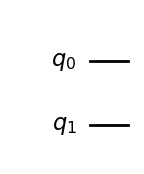

In [12]:
n = 2 # We are creating circuit with 2 qubits
grover_circuit = QuantumCircuit(n) # Initializes a new quantum circuit with those 2 qubits, at this point, the circuit is empty – it has qubits but no gates applied yet.
grover_circuit.draw(output='mpl')

Then we simply need to write out the commands for the circuit depicted above. First, we need to initialize the state $|s\rangle$. Let's create a general function (for any number of qubits) so we can use it again later:

In [13]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q) # applies a Hadamard gate to qubit q (creating superposition)
    return qc

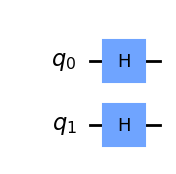

In [14]:
grover_circuit = initialize_s(grover_circuit, [0,1]) # gover_circuit -> our circuit, [0,1] -> qubits that needs to be put into superpsoyion state, mostly all input qubits. igff we had 3-qubits than we would wriote [0,1,2]
grover_circuit.draw(output = 'mpl')

Apply the Oracle for $|w\rangle = |11\rangle$. This oracle is specific to 2 qubits:

<span id="general_diffuser"></span>
We now want to apply the diffuser ($U_s$). As with the circuit that initialises $|s\rangle$, we'll create a general diffuser (for any number of qubits) so we can use it later in other problems.

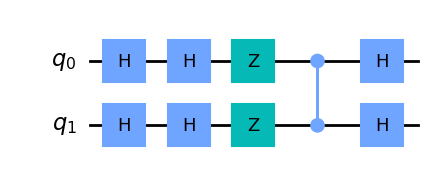

In [15]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw(output = 'mpl')

This is our finished circuit.

### 2.1.1 Experiment with Simulators <a id='2qubits-simulation'></a>

Let's run the circuit in simulation. First, we can verify that we have the correct statevector:

In [16]:
sv_sim = AerSimulator()
# Add this line BEFORE running the circuit
grover_circuit.save_statevector()

# Run on statevector simulator
sv_sim = AerSimulator()
result = sv_sim.run(grover_circuit).result()

# Extract the saved statevector
statevec = result.get_statevector()

# Display it in LaTeX
array_to_latex(statevec, prefix="|\\psi\\rangle =")

<IPython.core.display.Latex object>

As expected, the amplitude of every state that is not $|11\rangle$ is 0, this means we have a 100% chance of measuring $|11\rangle$:

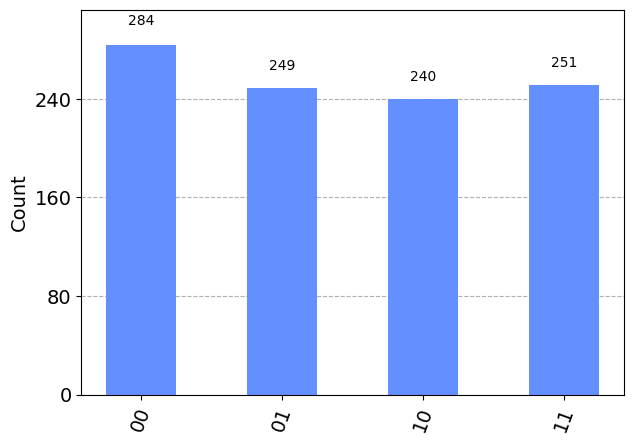

In [17]:
grover_circuit.measure_all()

qasm_sim = AerSimulator()
result = qasm_sim.run(grover_circuit).result()
counts = result.get_counts()
plot_histogram(counts)

## 3. Example: 3 Qubits <a id='3qubits'></a>

We now go through the example of Grover's algorithm for 3 qubits with two marked states $\lvert101\rangle$ and $\lvert110\rangle$. The quantum circuit to solve the problem using a phase oracle is:

![screenshot_1743359195276.png](<https://media-hosting.imagekit.io/a3be4bc691f74329/screenshot_1743359195276.png?Expires=1837967195&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=HQ6LeF0mWd-Qmde2UFOOoMfzKoq5-XcHRef7tV8YnPcyAB7RNtMecWGuue8W-5VpXXUIo0~Maojl~0GS1wVBnRHLUF75VNq3phsHY3Gwhe3lBjNH4N-OvI0JTCTjL1sY8HwgQpaHxmrnF-VkKXcAdGXoNj-euwOKPg7EivDnxNukAYJT2ag6JXIAdpttv~RqQr~~k9H0eZuQB6nFpJnMh9bUXYZktBj5QivnMaHbYuHxBynws5bf6YkkAvPpT3W4~pTXwGg8gbRHPZQoND1Ud-Pu9ObsiFsdIyL3zfyMuGQ26uUr5evAtsy6GF65xUZQvaF0Bs~tu~hm~R4CVAKGxA__>)

1. Apply Hadamard gates to $3$ qubits initialised to $\lvert000\rangle$ to create a uniform superposition:
   $$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} \left(
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle +
    \lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle \right)
   $$

2. Mark states $\lvert101\rangle$ and $\lvert110\rangle$ using a phase oracle:
   $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} \left(
    \lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle +
    \lvert100\rangle - \lvert101\rangle - \lvert110\rangle + \lvert111\rangle \right)
   $$

3. Perform the reflection around the average amplitude:
   1. Apply Hadamard gates to the qubits
      $$
      \lvert \psi_{3a} \rangle = \frac{1}{2} \left(
      \lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right)
      $$
   
   2. Apply X gates to the qubits
      $$
      \lvert \psi_{3b} \rangle = \frac{1}{2} \left(
      -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle +\lvert111\rangle \right)
      $$
   
   3. Apply a doubly controlled Z gate between the 1, 2 (controls) and 3 (target) qubits
      $$
      \lvert \psi_{3c} \rangle = \frac{1}{2} \left(
      -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right)
      $$
   
   4. Apply X gates to the qubits
      $$
      \lvert \psi_{3d} \rangle = \frac{1}{2} \left(
      -\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right)
      $$
   
   5. Apply Hadamard gates to the qubits
      $$
      \lvert \psi_{3e} \rangle = \frac{1}{\sqrt{2}} \left(
      -\lvert101\rangle -\lvert110\rangle \right)
      $$

4. Measure the $3$ qubits to retrieve states $\lvert101\rangle$ and $\lvert110\rangle$

Note that since there are 2 solutions and 8 possibilities, we will only need to run one iteration (steps 2 & 3).

### 3.1 Qiskit Implementation <a id='3qubit-implementation'></a>

We now implement Grover's algorithm for the above example for $3$-qubits and searching for two marked states $\lvert101\rangle$ and $\lvert110\rangle$. **Note:** Remember that Qiskit orders it's qubits the opposite way round to this resource, so the circuit drawn will appear flipped about the horizontal.

We create a phase oracle that will mark states $\lvert101\rangle$ and $\lvert110\rangle$ as the results (step 1).

In [18]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

In the last section, we used a diffuser specific to 2 qubits, in the cell below we will create a general diffuser for any number of qubits.

### Detail

    
Remember that we can create $U_s$ from $U_0$:

$$ U_s = H^{\otimes n} U_0 H^{\otimes n} $$

And a multi-controlled-Z gate ($MCZ$) inverts the phase of the state $|11\dots 1\rangle$:

$$
MCZ =
\begin{bmatrix}
 1 & 0 & 0 & \cdots & 0 \\
 0 & 1 & 0 & \cdots & 0 \\
 \vdots & \vdots & \vdots & \ddots & \vdots \\
 0 & 0 & 0 & \cdots & -1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\leftarrow \text{Add negative phase to} \; |11\dots 1\rangle\\
\end{aligned}
$$

Applying an X-gate to each qubit performs the transformation:

$$
\begin{aligned}
|00\dots 0\rangle & \rightarrow |11\dots 1\rangle\\
|11\dots 1\rangle & \rightarrow |00\dots 0\rangle
\end{aligned}
$$

So:

$$ U_0 = - X^{\otimes n} (MCZ) X^{\otimes n} $$

Using these properties together, we can create $U_s$ using H-gates, X-gates, and a single multi-controlled-Z gate:

$$ U_s = - H^{\otimes n} U_0 H^{\otimes n} = H^{\otimes n} X^{\otimes n} (MCZ) X^{\otimes n} H^{\otimes n} $$
    
Note that we can ignore the global phase of -1.

In [19]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

We'll now put the pieces together, with the creation of a uniform superposition at the start of the circuit and a measurement at the end. Note that since there are 2 solutions and 8 possibilities, we will only need to run one iteration.

In [20]:
from qiskit.circuit.library import MCXGate

def diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))

    # Apply multi-controlled-Z (using MCX + H)
    qc.h(n - 1)
    qc.append(MCXGate(n - 1), list(range(n - 1)) + [n - 1])
    qc.h(n - 1)

    qc.x(range(n))
    qc.h(range(n))
    return qc

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


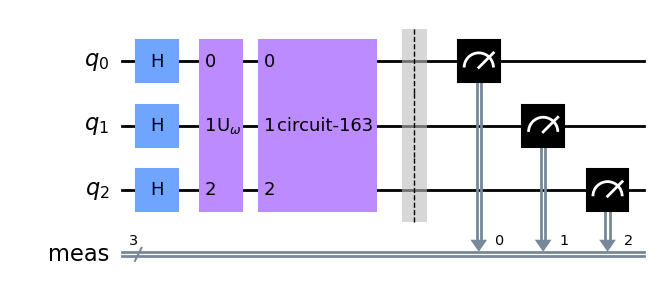

In [21]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw(output = 'mpl')

### 3.1.1 Experiment with Simulators  <a id='3qubits-simulation'></a>

We can run the above circuit on the simulator.

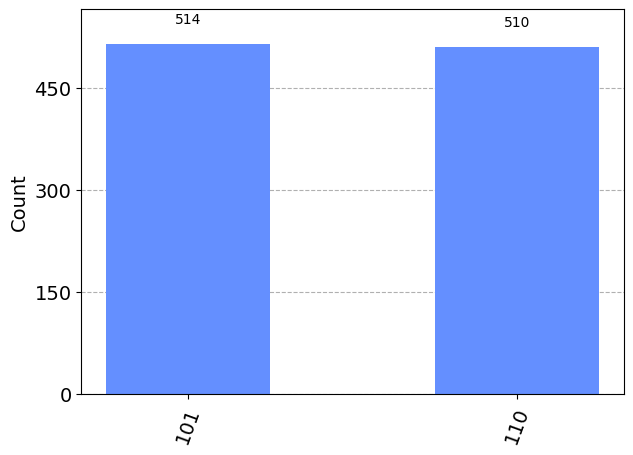

In [22]:
qasm_sim = AerSimulator()
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

As we can see, the algorithm discovers our marked states $\lvert101\rangle$ and $\lvert110\rangle$.

## 4. Problems <a id='problems'></a>

The function `grover_problem_oracle` below takes a number of qubits (`n`), and a `variant` and returns an n-qubit oracle. The function will always return the same oracle for the same `n` and `variant`. You can see the solutions to each oracle by setting `print_solutions = True` when calling `grover_problem_oracle`.

In [23]:
def grover_problem_oracle(n):
    oracle = QuantumCircuit(n)

    # Target state: |1101⟩
    # Flip qubits to make the desired target state |1111⟩
    oracle.x(0)  # flip q0 so we get |1101⟩ → |1111⟩

    # Multi-controlled Z using H + MCX + H trick
    oracle.h(n-1)
    oracle.mcx(list(range(n-1)), n-1)  # deprecated in some versions; use MCXGate if needed
    oracle.h(n-1)

    # Undo the flip
    oracle.x(0)

    oracle.name = "Oracle for |1101⟩"
    return oracle

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


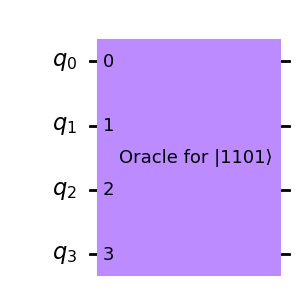

In [24]:
n = 4
oracle = grover_problem_oracle(n)
qc = QuantumCircuit(n)
qc.append(oracle, range(n))
qc.draw('mpl')

1. `grover_problem_oracle(4, variant=2)` uses 4 qubits and has 1 solution.    
   a. How many iterations do we need to have a > 90% chance of measuring this solution?    
   b. Use Grover's algorithm to find this solution state.
   c. What happens if we apply more iterations than the number we calculated in problem 1a above? Why?

2. With 2 solutions and 4 qubits, how many iterations do we need for a >90% chance of measuring a solution? Test your answer using the oracle `grover_problem_oracle(4, variant=1)` (which has two solutions).

3. Create a function, `grover_solver(oracle, iterations)` that takes as input:
    - A Grover oracle as a gate (`oracle`)
    - An integer number of iterations (`iterations`)
    
   and returns a `QuantumCircuit` that performs Grover's algorithm on the '`oracle`' gate, with '`iterations`' iterations.

## 4.1 Solving Sudoku using Grover's Algorithm <a id="sudoku"></a>

The oracles used throughout this chapter so far have been created with prior knowledge of their solutions. We will now solve a simple problem using Grover's algorithm, for which we do not necessarily know the solution beforehand. Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

- No column may contain the same value twice
- No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

![screenshot_1743359313385.png](<https://media-hosting.imagekit.io/2cb9c118f80c4df7/screenshot_1743359313385.png?Expires=1837967314&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=Wn~WPMVUGsolWWlwXut1l40L3SUUtuI-69HYH2041iMJ9UFHpJAY2HnsXk81xxnW6PKRGY3NBTD6HlJeyCCTFoXqspT38Qy8AKqSx~-i9E7GJbD06YpxN~z7RaJKXDmgmGARwLMQsgGJ7ZdsqVqv5jFJUZj~9JYNMmrJeovcLlAYQsR1UqKcaH8NfRFFHuJy4NNnN8s8rAL2~pLR5wMNkDNUkqGDgnZ-34bvGaEgfNLAN1x2RTFVU05WgBnwLjOBU-SFtDFgGW8wNx7Wv5raN6QX7M-4-uOOoQKV6CRU4mg9hWB7SNe2FWb0b6vhhCrCVdehm71as0XomPtENJb~bA__>)

we want our circuit to output a solution to this sudoku.

Note that, while this approach of using Grover's algorithm to solve this problem is not practical (you can probably find the solution in your head!), the purpose of this example is to demonstrate the conversion of classical [decision problems](https://en.wikipedia.org/wiki/Decision_problem) into oracles for Grover's algorithm.

### 4.1.1 Turning the Problem into a Circuit

We want to create an oracle that will help us solve this problem, and we will start by creating a circuit that identifies a correct solution. Similar to how we created a classical adder using quantum circuits in [_The Atoms of Computation_](/course/ch-states/the-atoms-of-computation), we simply need to create a _classical_ function on a quantum circuit that checks whether the state of our variable bits is a valid solution.

Since we need to check down both columns and across both rows, there are 4 conditions we need to check:

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

Remember we are comparing classical (computational basis) states. For convenience, we can compile this set of comparisons into a list of clauses:

In [25]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

We will assign the value of each variable to a bit in our circuit. To check these clauses computationally, we will use the `XOR` gate (we came across this in the atoms of computation).

In [26]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

Convince yourself that the `output0` bit in the circuit below will only be flipped if `input0 ≠ input1`:

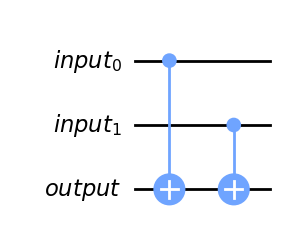

In [27]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw(output ='mpl')

This circuit checks whether `input0 == input1` and stores the output to `output0`. To check each clause, we repeat this circuit for each pairing in `clause_list` and store the output to a new bit:

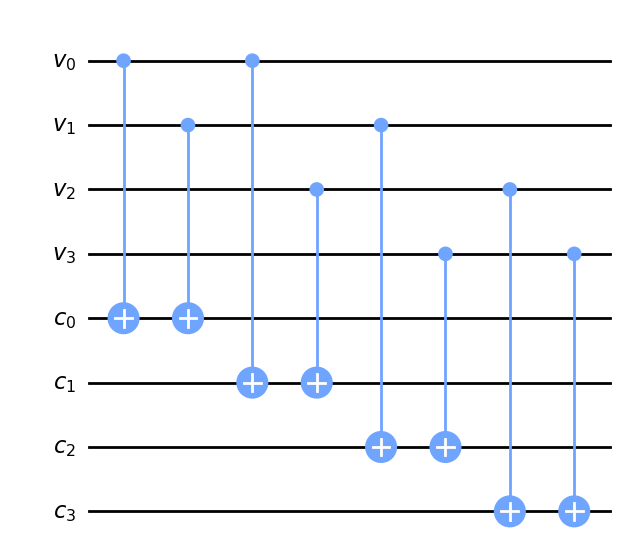

In [28]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw(output ='mpl')

The final state of the bits `c0, c1, c2, c3` will only all be `1` in the case that the assignments of `v0, v1, v2, v3` are a solution to the sudoku. To complete our checking circuit, we want a single bit to be `1` if (and only if) all the clauses are satisfied, this way we can look at just one bit to see if our assignment is a solution. We can do this using a multi-controlled-Toffoli-gate:

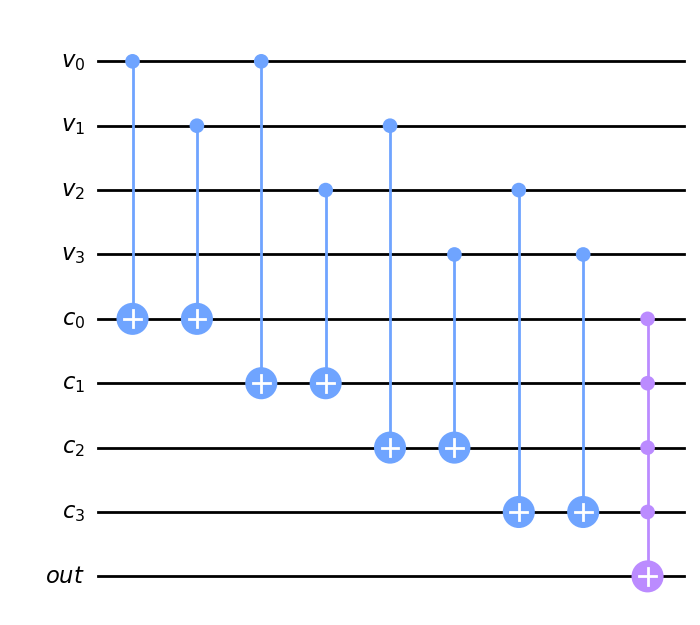

In [29]:

# Create registers
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
for i, clause in enumerate(clause_list):
    XOR(qc, clause[0], clause[1], clause_qubits[i])

# Flip output if all clauses are satisfied (using multi-controlled X)
qc.append(MCXGate(len(clause_qubits)), clause_qubits[:] + [output_qubit[0]])

qc.draw('mpl')


In [30]:
def sudoku_oracle(qc, clause_list, clause_qubits, output_qubit):
    # Compute clauses
    for i, clause in enumerate(clause_list):
        XOR(qc, clause[0], clause[1], clause_qubits[i])

    # Flip output bit if all clauses are satisfied
    qc.append(MCXGate(len(clause_qubits)), clause_qubits[:] + [output_qubit[0]])

    # Uncompute clauses
    for i, clause in enumerate(clause_list):
        XOR(qc, clause[0], clause[1], clause_qubits[i])

sudoku_oracle(qc, clause_list, clause_qubits, output_qubit)

In summary, the circuit above performs:

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = \Bigg\{
\begin{aligned}
|x\rangle|0\rangle|\text{out}_0\rangle \quad \text{for} \; x \neq \omega \\
|x\rangle|0\rangle\otimes X|\text{out}_0\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

and if the initial state of $|\text{out}_0\rangle = |{-}\rangle$,:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

### 4.1.3 The Full Algorithm

All that's left to do now is to put all these components together.

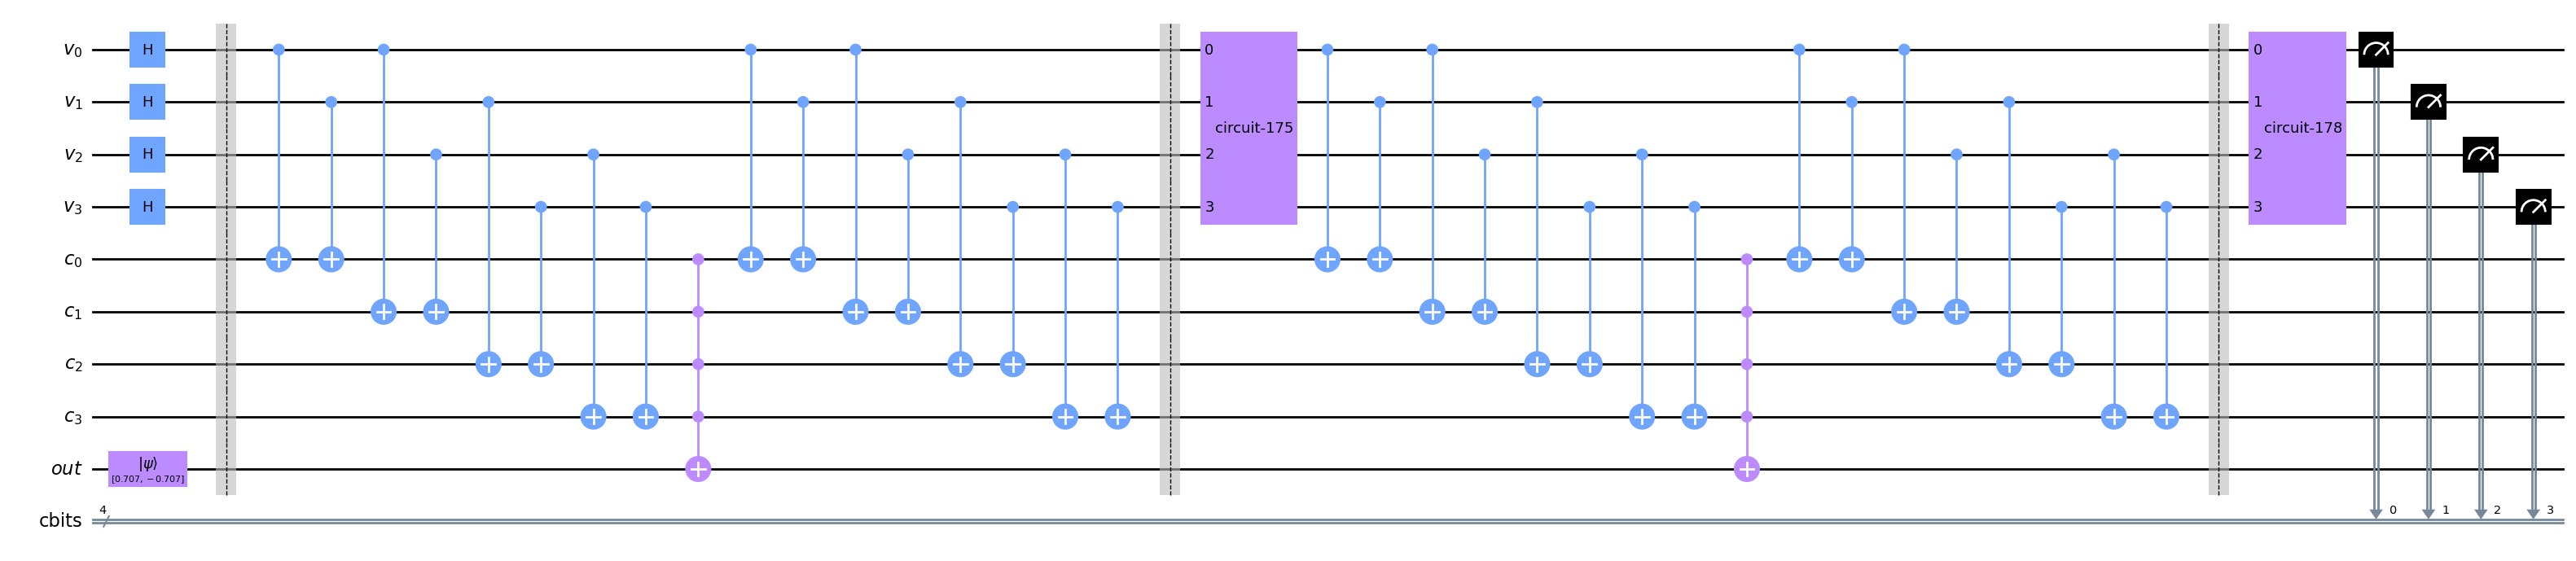

In [31]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits, output_qubit)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits, output_qubit)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1, output = 'mpl')

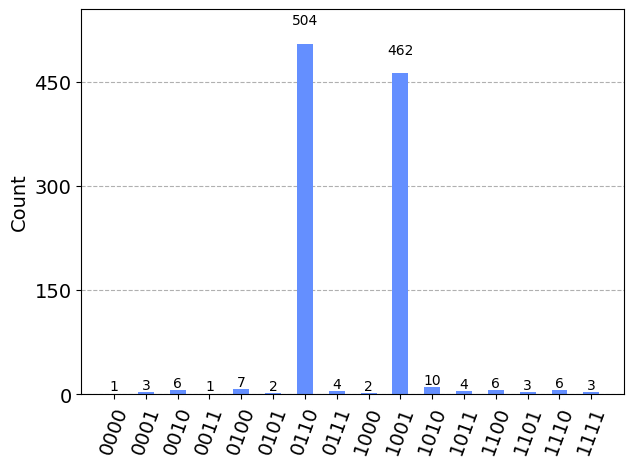

In [32]:
# Simulate and plot results
qasm_simulator = AerSimulator()
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

There are two bit strings with a much higher probability of measurement than any of the others, `0110` and `1001`. These correspond to the assignments:
```
v0 = 0
v1 = 1
v2 = 1
v3 = 0
```
and
```
v0 = 1
v1 = 0
v2 = 0
v3 = 1
```
which are the two solutions to our sudoku! The aim of this section is to show how we can create Grover oracles from real problems. While this specific problem is trivial, the process can be applied (allowing large enough circuits) to any decision problem. To recap, the steps are:



### Task

1. Create a reversible classical circuit that identifies a correct solution
2. Use phase kickback and uncomputation to turn this circuit into an oracle
3. Use Grover's algorithm to solve this oracle

<ipython-input-41-6888d1352bbb>:17: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(list(range(n - 1)), n - 1)  # multi-controlled Toffoli
<ipython-input-41-6888d1352bbb>:30: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed in the Qiskit 1.0.0 release. Use QuantumCircuit.mcx as direct replacement.
  qc.mct(list(range(n - 1)), n - 1)
/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


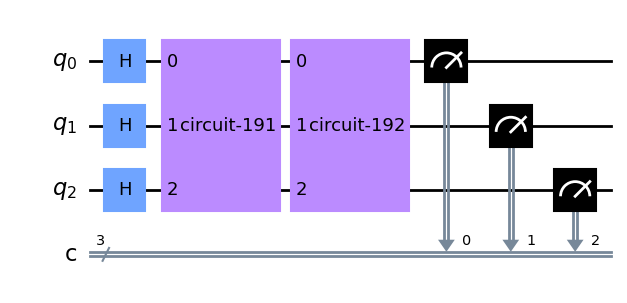

In [41]:
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np



n_qubits = 3
target_state = '101'


def grover_oracle(n, target):
    qc = QuantumCircuit(n)
    for i, bit in enumerate(reversed(target)):
        if bit == '0':
            qc.x(i)
    qc.h(n - 1)
    qc.mct(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    for i, bit in enumerate(reversed(target)):
        if bit == '0':
            qc.x(i)
    return qc

def grover_diffusion(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mct(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

qc = QuantumCircuit(n_qubits, n_qubits)


qc.h(range(n_qubits))


oracle = grover_oracle(n_qubits, target_state)
diffuser = grover_diffusion(n_qubits)
qc.append(oracle.to_gate(), range(n_qubits))
qc.append(diffuser.to_gate(), range(n_qubits))

qc.measure(range(n_qubits), range(n_qubits))
qc.draw('mpl')


<ipython-input-42-119f50bfd9d9>:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  results = sim.run(qobj).result()


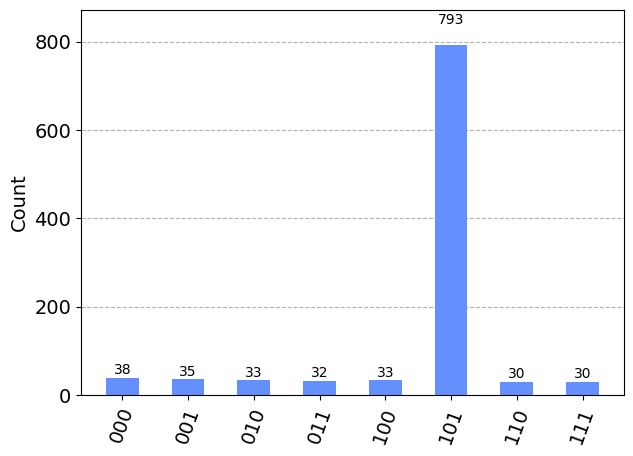

In [42]:
sim = Aer.get_backend('qasm_simulator')
tqc = transpile(qc, sim)
qobj = assemble(tqc, shots=1024)
results = sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)


## 4.2 The Triangle-finding Problem Using Grover <a id='tri'></a>


One of the famous graph theory problems is the triangle-finding problem. In the triangle-finding problem, we are given a graph that may or may not contain a triangle. Our task is to find the triangle/s within the graph and point out the nodes that form the triangle. For example, the graph below is a 4-node graph with a triangle between nodes `0`,`1`, and `2`.     


![screenshot_1743360327882.png](<https://media-hosting.imagekit.io/4cfdb235a4754c76/screenshot_1743360327882.png?Expires=1837968330&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=IY-bJJe1xyQETlo3XjT4QtBk2zGrBvZnfzHOC6HotgtXR19rigcibg4SIjBmZGnVrC4NJta~px1579077lIQ5rCxkj7-v-r22U8q0h0DPcl7vVePWfdO~5Iy2uCgl5S-dy02Wn6vC3cds4g1mdbWXSPp9u4Ou1tD0pQnXoJ7Zs71IVLScPRuvicXvbLZ-XwUSAfh9a0ttfFf9HR9rtLfHleAv8~EKp0TRPUDbsCJ88yLTAUCu5ECkygaO5XgfbyCZjgnWhb7jw~xExF7PPdNm-GDWjeEUk23IxLiuEmKSUAMN-2Bplpy2TMKnl-tk9sYPFHE~8ARgkvsNjxKq4w-vw__>)


We can apply Grover's algorithm to this problem, we are going to give the algorithm a list of _edges_ and the number of nodes in the graph. The algorithm, then, will do the rest. It will try to check if there's a triangle in the graph or not, and if so it will mark the nodes forming that triangle.   


Now, let's go through Grover's algorithm steps and see how can we construct each step to solve the triangle finding problem. But first, let's define our input, which is the list of edges.

In [33]:
#Edges list
edges =[(0, 1), (0, 2), (1, 2), (2, 3)]
#Number of nodes
n_nodes = 4

### 4.2.1 The state preparation

To solve the problem, let's first focus on the example above, which is the case of finding a triangle in a 4-node graph. to do that, we need to go over all subgraphs within our graph and check if any of them a triangle. To do that we will need 4-qubits, each qubit represents a node in the graph. The state of the qubit will indicate whether the node in any subgraph or not. For example, in the graph above, the triangle is between nodes 0,1, and 2, we can rephrase that using the state `1110`. The nodes with state 1 are in the subgraph (triangle) and the node with state 0 is not.   

For the state preparation, we will need to create a superposition of all possible states `0000`, to `1111`, which can be done simply using `4` Hadamard gates. Doing so, will we need to rotate over the oracle and diffusion `3` times.  
But, if each `1` in the state represent an active node, we don't really need to look through the entire Hilbert space, we only need to look through the subgraphs with three nodes.    

This is a good example of using another type of symmetric states to prepare the search space. Here since we only need to consider states with three 1's, we can think of another way to form our search space. One way to create a superposition over only states with three active nodes is through using the W-state followed by `4 NOT gates`. This will decrease the number of rotations needed from `3` to `1`.

So, we first need to implement the W-state. W-states have the form:

$$|W\rangle = {\frac{1}{{\sqrt{n}}}}(|100...0\rangle + ... + |01...0\rangle + | 00...01\rangle) $$

We need to construct $|W_{3}\rangle$ states.

In [34]:
# Iskorištena je implementacija W-stanja za stvaranje kvantne superpozicije s točno jednom jedinicom raspodijeljenom po više kubita

def control_rotation(qcir, cQbit, tQbit, theta):
    """
    Implementira kontroliranu rotaciju pomoću osnovnih kvantnih vrata (unitarnih i CNOT).

    Argumenti:
    - qcir: instanca QuantumCircuit.
    - cQbit: kontrolni kubit.
    - tQbit: ciljani kubit.
    - theta: kut rotacije (u stupnjevima).

    Povrat:
    - modificirani QuantumCircuit s primijenjenom kontroliranom rotacijom.
    """
    # Računamo transformirani kut (theta') iz theta koristeći asin(cos(theta/2))
    theta_dash = math.asin(math.cos(math.radians(theta / 2)))

    # Primjenjujemo rotaciju theta' na ciljni kubit
    qcir.u(theta_dash, 0, 0, tQbit)

    # Primjenjujemo CNOT između kontrolnog i ciljnog kubita
    qcir.cx(cQbit, tQbit)

    # Primjenjujemo obrnutu rotaciju (-theta') kako bismo završili rotaciju ovisnu o kontrolnom kubitu
    qcir.u(-theta_dash, 0, 0, tQbit)

    return qcir


def wn(qcir, qbits):
    """
    Generira W-stanje koristeći `control_rotation` funkciju.

    Argumenti:
    - qcir: instanca QuantumCircuit koja će se nadopuniti s W-stanjem.
    - qbits: lista kvantnih kubita koji će se koristiti.

    Povrat:
    - modificirani QuantumCircuit s W-stanjem.
    - lista korištenih kubita.
    """
    for i in range(len(qbits)):
        if i == 0:
            # Prvi kubit postavljamo u stanje |1⟩
            qcir.x(qbits[0])
            qcir.barrier()
        else:
            # Izračun vjerojatnosti i pripadajućeg kuta rotacije za svaki sljedeći kubit
            p = 1 / (len(qbits) - (i - 1))
            theta = math.degrees(math.acos(math.sqrt(p)))
            theta = 2 * theta  # Skaliramo kut jer se koristi u kontroliranoj rotaciji

            # Primjenjujemo kontroliranu rotaciju i CNOT između kubita
            qcir = control_rotation(qcir, qbits[i - 1], qbits[i], theta)
            qcir.cx(qbits[i], qbits[i - 1])
            qcir.barrier()
    return qcir, qbits


# Kreiramo registar za podcircuit (n_nodes kubita)
sub_qbits = QuantumRegister(n_nodes)

# Kreiramo kvantni podsklop za pripremu W-stanja
sub_cir = QuantumCircuit(sub_qbits, name="state_prep")

# Primjenjujemo funkciju za izgradnju W-stanja
sub_cir, sub_qbits = wn(sub_cir, sub_qbits)

# Invertiramo sve kubite (X-vrata) kako bi svi bili u stanju |0⟩ osim jednog u |1⟩
sub_cir.x(sub_qbits)

# Pretvaramo kreirani podsklop u instrukciju kako bi se mogao koristiti kao jedna operacija u glavnom sklopu
stat_prep = sub_cir.to_instruction()

# Pripremamo i inverzni operator (potreban za Groverovu difuziju)
inv_stat_prep = sub_cir.inverse().to_instruction()


### 4.2.2 The oracle

The oracle is what's gonna mark the correct answer. In these cases, the oracle needs to take every subgraph and count the number of edges in that subgraph. If the number of edges is `3`, then we have a triangle, if not, it will proceed to the next subgraph.    

![screenshot_1743360390281.png](<https://media-hosting.imagekit.io/8895da6364394c52/screenshot_1743360390281.png?Expires=1837968390&Key-Pair-Id=K2ZIVPTIP2VGHC&Signature=RgxtAYxetl9m2p9khefBUjr8YiXzBalZkfsYCfO4UkzTVsBAz3jQ7bOqSwDkj4Rf1wZ1IGombn8MYDibEHzG0PeLRd1n7sH2ahc5DXjh93VHLQR6WZNY-OAZyysZQ8eukoo-qnMErjPfy-OGhQK-0xfS9Q0l42tgGYVczo~PDj~fbedoKNa8Q3cda~AGlswszCgJOJ4AQBTbel-J182H0DtHVW7ONPM4K4IdC6qX8YEx7HK2GSPDPyOxKjjIy2CJwS4pjRsfyCj~xP~JyWvcVHScLHJmnyG3L~t9W9KgIn6QC7FVrMdyNsnDaqTYAvmtAoS71UNAb~zH-FkqDbBEcw__>)

For every edge in the graph, we will need one or two `CNOT` gates. These `CNOT` gates will apply to two ancillary qubits, that should be in state `11` if a triangle is found. The number of ancillary qubits here is two because a triangle has `3 edges` that is $11_{b}$. Then the final step in the oracle is to apply one more `Toffoli`, that will only be active if a triangle is found by changing the state of another qubit, let's call it, `tri_flag`, to `1`.

In [35]:
from qiskit.circuit.library import MCXGate  # Uvoz višestruko kontroliranog X-gata (Toffoli gate s više ulaza)

def edge_counter(qc, qubits, anc, flag_qubit, k):
    bin_k = bin(k)[2:][::-1]
    l = []
    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
    # Ispravka: koristi mcx umjesto mct
    qc.mcx(l, flag_qubit, [anc], mode='recursion')



def oracle(n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base):
    """
    Orakul koji identificira trokut u grafu (3 čvora međusobno spojena rubovima).

    Argumenti:
    - n_nodes: broj čvorova u grafu
    - edges: popis rubova (svaki rub je par (i, j))
    - qc: instanca kvantnog sklopa
    - nodes_qubits: qubiti koji predstavljaju čvorove grafa
    - edge_anc: pomoćni qubiti koji predstavljaju postoji li rub
    - ancilla: pomoćni qubiti za višekontrolirane operacije
    - neg_base: qubit koji će se postaviti u |1⟩ ako je trokut pronađen
    """
    k = 3  # broj rubova u trokutu

    # 1. Brojanje rubova između čvorova
    qc.barrier()

    # Inicijalno, računamo jedan rub pomoću CCX (Toffoli) gate
    qc.ccx(nodes_qubits[edges[0][0]], nodes_qubits[edges[0][1]], edge_anc[0])

    # Iteracija kroz preostale rubove, koristeći višekontrolirane X-gatove (MCXGate)
    for i in range(1, len(edges)):
        # Dodaj MCXGate (3 ulaza) između dva čvora i edge_anc[0], koristi edge_anc[1] kao izlaz
        qc.append(MCXGate(3), [
            nodes_qubits[edges[i][0]],
            nodes_qubits[edges[i][1]],
            edge_anc[0],
            edge_anc[1]
        ])
        # Ponovno računaj trenutni rub pomoću Toffoli-gatea
        qc.ccx(nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0])

    # ----------------------------------------------------------------------------------------------------------
    # 2. Provjera je li broj aktivnih rubova odgovarao trokutu (3 ruba)
    edg_k = int((k / 2) * (k - 1))  # broj veza između 3 čvora (potrebno 3 ruba → 3 kombinacije od 2)
    edge_counter(qc, edge_anc, ancilla[0], neg_base[0], edg_k)
    # ----------------------------------------------------------------------------------------------------------

    # 3. Reverzna operacija za "uncompute" pomoćnih qubita (da ne utječu na daljnju kvantnu evaluaciju)
    for i in range(len(edges) - 1, 0, -1):
        # Resetiramo edge_anc qubit dvostrukim CCX (kompenzacija ranijih operacija)
        qc.ccx(nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0])
        qc.ccx(nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0])

        # Vraćamo stanje pomocu MCXGate koji je korišten ranije
        qc.append(MCXGate(3), [
            nodes_qubits[edges[i][0]],
            nodes_qubits[edges[i][1]],
            edge_anc[0],
            edge_anc[1]
        ])

    # Vraćamo stanje i za prvi rub
    qc.ccx(nodes_qubits[edges[0][0]], nodes_qubits[edges[0][1]], edge_anc[0])

    qc.barrier()  # označavamo kraj orakula


### 4.2.3 The diffusion operator

As we said before, the diffusion operator construction depends on the type of state preparation we used, in this case, the W-state. So, we need the inverses W-state, a multi-controlled Z gate and the original W-state to form the diffusion operator.

In [36]:
def cnz(qc, num_control, node, anc):
    """
    Konstruira višekontrolirani Z-gate (multi-controlled Z).

    Argumenti:
    - qc: instanca QuantumCircuit u koju se dodaju gateovi.
    - num_control: broj kontrolnih qubita (koliko ih mora biti u |1⟩ da bi se primijenio Z-gate).
    - node: lista qubita, prvo dolaze kontrolni, a zatim cilj (target).
    - anc: pomoćni qubiti (ancilla), potrebni za konstrukciju ako je više od 2 kontrolna qubita.
    """

    if num_control > 2:
        # Koristi se rekurzivna konstrukcija višekontroliranog Z pomoću CCX i jednog CZ

        # 1. Kombiniraj prve dvije kontrole u prvi pomoćni qubit
        qc.ccx(node[0], node[1], anc[0])

        # 2. Iterativno dodaj preostale kontrole koristeći lanac CCX gateova i ancilla qubita
        for i in range(num_control - 2):
            qc.ccx(node[i+2], anc[i], anc[i+1])

        # 3. Primijeni CZ između zadnjeg ancilla i ciljnog qubita (npr. node[num_control])
        qc.cz(anc[num_control - 2], node[num_control])

        # 4. "Uncompute" (resetiraj) ancilla qubite obrnutim redoslijedom
        for i in reversed(range(num_control - 2)):
            qc.ccx(node[i+2], anc[i], anc[i+1])

        # 5. Resetiraj i prvi ancilla qubit
        qc.ccx(node[0], node[1], anc[0])

    elif num_control == 2:
        # Ako su samo 2 kontrolna qubita, koristimo H-CCX-H trik za implementaciju CZ
        # Ovo radi jer: H • CCX • H = CCZ (kontrolirani-Z)
        qc.h(node[2])                   # Pretvori Z-bazu u X-bazu
        qc.ccx(node[0], node[1], node[2])  # Toffoli
        qc.h(node[2])                   # Vrati u Z-bazu

    elif num_control == 1:
        # Ako postoji samo 1 kontrolni qubit, samo se primjenjuje CZ između kontrolnog i ciljnog
        qc.cz(node[0], node[1])

In [37]:
def grover_diff(qc, nodes_qubits, edge_anc, ancilla, stat_prep, inv_stat_prep):
    """
    Implementacija Groverove difuzije (tzv. "inversion about the mean").

    Argumenti:
    - qc: instanca kvantnog sklopa.
    - nodes_qubits: lista qubita koji predstavljaju varijable pretraživanja.
    - edge_anc: pomoćni qubiti (ovdje se ne koriste, ali se mogu koristiti u proširenjima).
    - ancilla: pomoćni (ancilla) qubiti potrebni za višekontrolirani Z.
    - stat_prep: instrukcija za pripremu početnog stanja (npr. W-stanje).
    - inv_stat_prep: inverzna verzija stat_prep instrukcije.
    """

    # 1. Primijeni inverznu pripremu stanja
    # Ovo "poništava" početnu superpoziciju i vraća stanje bliže |0⟩^n
    qc.append(inv_stat_prep, qargs=nodes_qubits)

    # 2. Primijeni X-vrata na sve qubite
    # Mijenja bazu radi refleksije oko stanja |s⟩ (sve jedinice)
    qc.x(nodes_qubits)

    # ================== VIŠEKONTROLIRANI Z ==================
    # 3. Primijeni Z-gate s više kontrola
    # Refleksija oko nultog stanja |0⟩^n — jezgra Groverove difuzije
    cnz(qc, len(nodes_qubits) - 1, nodes_qubits[::-1], ancilla)
    # ========================================================

    # 4. Vraćanje u početnu bazu s još jednom serijom X-vrata
    qc.x(nodes_qubits)

    # 5. Ponovno primijeni pripremu stanja
    # Tako vraćamo stanje u superpoziciju, ali sada s pojačanim amplitudama rješenja
    qc.append(stat_prep, qargs=nodes_qubits)

### 4.2.4 Putting it all together

Now that we have all the components of the algorithm built and running, we can put them together.

In [38]:
# Funkcija koja konstruira Groverov kvantni algoritam za traženje trokuta u grafu
def grover(n_nodes, stat_prep, inv_stat_prep):
    """
    Groverov algoritam za pretragu podskupova čvorova koji čine trokut u grafu.

    Argumenti:
    - n_nodes: broj čvorova u grafu.
    - stat_prep: instrukcija za pripremu početnog stanja (npr. W-stanje).
    - inv_stat_prep: inverzna verzija stat_prep instrukcije.

    Povrat:
    - QuantumCircuit instanca s cijelom Groverovom logikom.
    """

    # N = ukupan broj mogućih kombinacija 3 čvora (nCr) — jer tražimo trokute
    N = math.comb(n_nodes, 3)

    # --- DEFINICIJA REGISTARA ---
    nodes_qubits = QuantumRegister(n_nodes, name='nodes')         # qubiti koji predstavljaju čvorove
    edge_anc = QuantumRegister(2, name='edge_anc')                # pomoćni qubiti za provjeru rubova
    ancilla = QuantumRegister(n_nodes-2, name='cccx_diff_anc')    # pomoćni qubiti za višekontrolirane gateove
    neg_base = QuantumRegister(1, name='check_qubits')            # qubit koji signalizira da je trokut pronađen
    class_bits = ClassicalRegister(n_nodes, name='class_reg')     # klasični registri za mjerenje rezultata
    tri_flag = ClassicalRegister(3, name='tri_flag')              # dodatni klasični registri (nije obavezno korišteno)

    # Inicijalizacija kvantnog sklopa
    qc = QuantumCircuit(nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag)

    # Inicijalizacija qubita koji će signalizirati rješenje u stanje |−⟩ = H•X|0⟩
    qc.x(neg_base[0])
    qc.h(neg_base[0])

    # Priprema početnog stanja (npr. W-stanje)
    qc.append(stat_prep, qargs=nodes_qubits)
    qc.barrier()

    # Izračun optimalnog broja iteracija Groverovog operatora
    iterations = math.floor(math.pi / 4 * math.sqrt(N))

    # Glavna petlja: primjena Groverovih iteracija
    for i in np.arange(iterations):
        qc.barrier()
        # Primjena orakula koji označava rješenja (čvorove koji čine trokut)
        oracle(n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base)
        qc.barrier()
        # Difuzija: refleksija oko prosjeka kako bi se pojačale amplitude rješenja
        grover_diff(qc, nodes_qubits, edge_anc, ancilla, stat_prep, inv_stat_prep)

    # Mjerenje čvorova u klasične bitove — vraćamo rješenja trokuta
    qc.measure(nodes_qubits, class_bits)

    return qc

Now, let's run the code and plot the histogram to see if our algorithm works as expected.

/usr/local/lib/python3.11/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


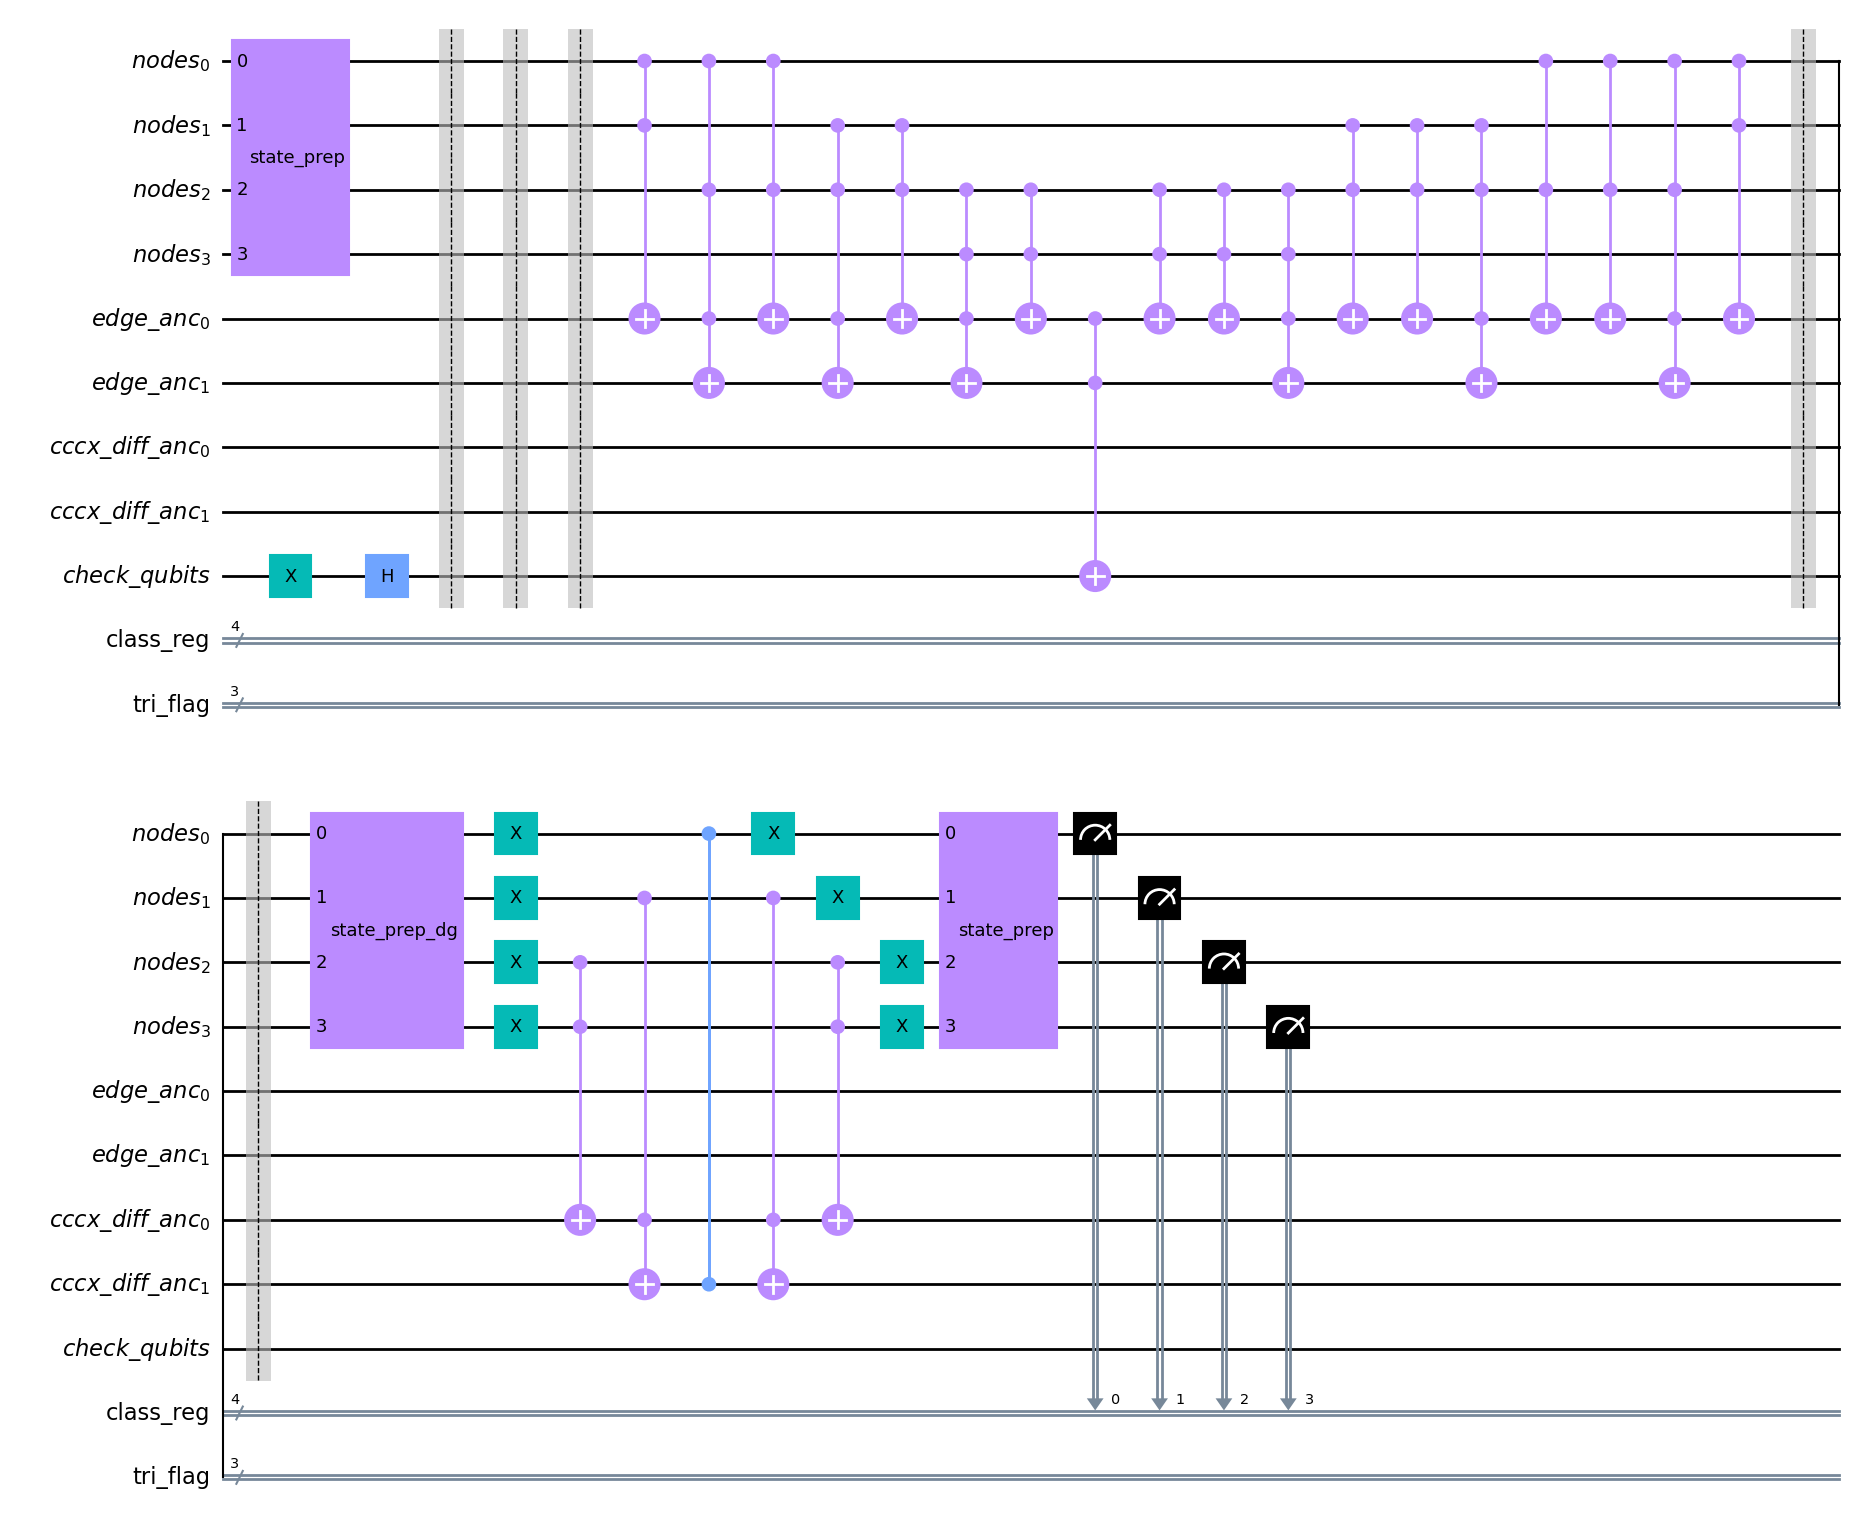

In [39]:
qc = grover(n_nodes, stat_prep, inv_stat_prep)
# Draw circuit
qc.draw('mpl')

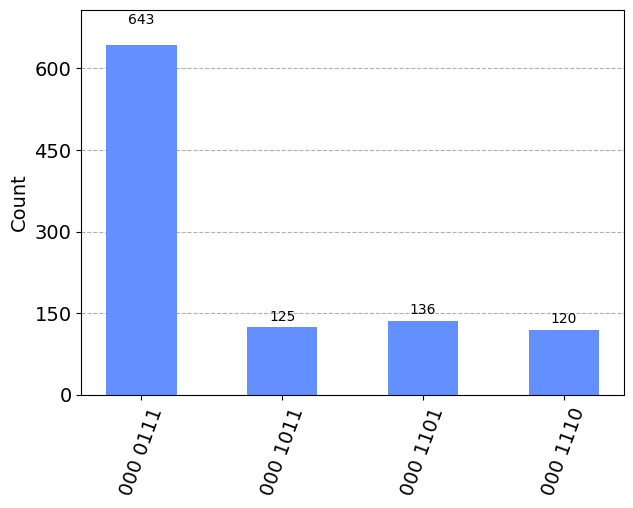

In [40]:
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit import transpile

# Priprema simulatora
qasm_simulator = AerSimulator()

# Transpilacija kvantnog sklopa za simulator
transpiled_qc = transpile(qc, qasm_simulator)

# Izvršavanje kvantnog sklopa
result = qasm_simulator.run(transpiled_qc, shots=1024).result()

# Dohvat rezultata mjerenja
counts = result.get_counts()

# Prikaz histograma
plot_histogram(counts)

### Task : Triangle Detection in a Quantum Graph Using Grover's Algorithm

Imagine an undirected graph represented using quantum qubits, where each node can be "activated" (i.e., included in a potential solution). The goal is to find all combinations of 3 nodes that form a triangle — a set of 3 nodes with 3 mutual edges.

Using Grover's algorithm implemented in Qiskit, your job is to:

1. Prepare a W-state to initialize the superposition over all combinations of 3 nodes.
2. Define an oracle that marks states which represent triangles.
3. Implement Grover's diffusion operator.
4. Run a quantum simulation and analyze the measurement results.

Complete the implementation of a quantum algorithm that finds triangles in the following graph with 5 nodes and edges:

edges = [(0, 1), (1, 2), (2, 0), (3, 4)]

This graph contains one triangle (0–1–2) and one isolated edge (3–4).

For successful compliting this task you should:
1. Implement the oracle(...) function that checks whether a selected node combination forms a triangle.
2. Build the grover(...) function using: A W-state as the initial superposition, your oracle function, Grover's diffusion operator with a multi-controlled Z-gate.
3. Simulate the quantum circuit and plot the measurement histogram.
4. Identify the most probable solution from the histogram and interpret it as a set of graph nodes.

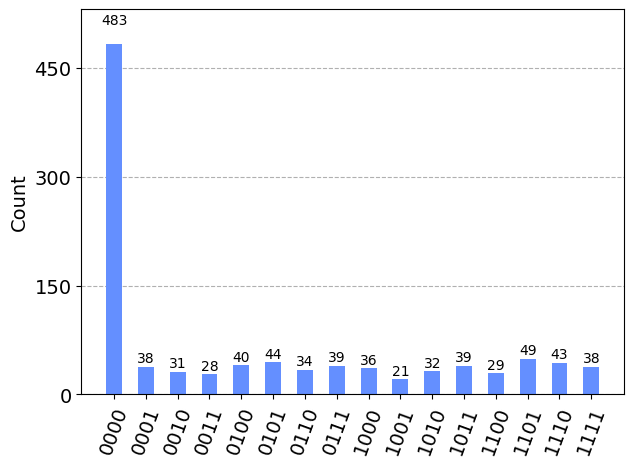

In [67]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
import itertools
import matplotlib.pyplot as plt
import math

nodes = [0, 1, 2, 3, 4]
edges = [(0, 1), (1, 2), (2, 0), (3, 4)]
combinations = list(itertools.combinations(nodes, 3))
triangle_indices = [i for i, c in enumerate(combinations)
                    if all((a, b) in edges or (b, a) in edges for a, b in itertools.combinations(c, 2))]

n_qubits = math.ceil(math.log2(len(combinations)))

target_index = triangle_indices[0]
target_bin = format(target_index, f"0{n_qubits}b")

def oracle(n, target_bin):
    qc = QuantumCircuit(n)
    for i, bit in enumerate(reversed(target_bin)):
        if bit == '0':
            qc.x(i)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    for i, bit in enumerate(reversed(target_bin)):
        if bit == '0':
            qc.x(i)
    return qc


def diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

def grover():
    qc = QuantumCircuit(n_qubits, n_qubits)

    qc.h(range(n_qubits))

    qc.append(oracle(n_qubits, target_bin).to_gate(), range(n_qubits))

    qc.append(diffuser(n_qubits).to_gate(), range(n_qubits))

    qc.measure(range(n_qubits), range(n_qubits))

    return qc

backend = Aer.get_backend('qasm_simulator')

qc = grover()

tqc = transpile(qc, backend)

result = backend.run(tqc, shots=1024).result()
counts = result.get_counts()

plot_histogram(counts)

In [69]:
most_likely = max(counts, key=counts.get)
combo_index = int(most_likely, 2)
print(combinations[combo_index])


(0, 1, 2)
